# Tensor Network Representations of Parton Wave functions
## Term project #6
### Tensor networks 2025
#### Philipp Heinrich, Schäffer Bálint

In [1]:
using JLD2
using DelimitedFiles
path = "C:\\Users\\schba\\PycharmProjects\\ML4Q\\jl_data\\"
#save("C:\\Users\\schba\\PycharmProjects\\ML4Q\\project_vars.jld2", "MPS_iter", MPS_iter)
#@load "project_vars.jld2" MPS_iter

"C:\\Users\\schba\\PycharmProjects\\ML4Q\\jl_data\\"

## Steps
0. Figure out the fermionic / spin representations ($S\rightarrow c\rightarrow\sigma$)
1. Construct fermionic vacuum state as MPS and $d_k^\dagger$ as MPO and construct the Fermi sea
2. Plot the entanglement entropy
3. Constuct Wannier orbitals and apply them, plot the entanglement entropy
4. Do the same using the left-meets-right method
5. Apply Gutzwiller projection and compute ground-state energy using DMRG
6. Compute the spin-spin correlation function and compare to exact values
7. Prepare a presentation
8. Seem like we know what we're doing, get a good grade

## _(a)_ The Haldane-Shastry model
$$H_\mathrm{HS}=\sum_{p<q}\frac{\pi^2\vec{S}_p\cdot\vec{S}_q}{N^2\sin^2{\frac{\pi}{N}(p-q)}}$$
* $N=32$
* Abrikosov Fermion representation: $S_j^a=\frac{1}{2}\sum_{\alpha\beta}c_{j\alpha}^\dagger\tau_{\alpha\beta}^ac_{j\beta}$
* Separate the sites into spin-up and spin-down sites: $\sum_{j=1}^N\sum_{\alpha=\uparrow,\downarrow}=\sum_{l=1}^{2N}$
* Jordan-Wigner transformation: $c_l^\dagger=\sigma_{l<}^z\sigma_l^+$ with $\sigma_{l<}^z=\Pi_{i=1}^{l-1}\sigma_i^z$
* The fermionic vacuum: $\ket{0}\rightarrow\ket{\downarrow...\downarrow}$
### Preparing the vacuum state

In [2]:
using LinearAlgebra

id = I(2)  # identity matrix for spin-1/2
sz = [1 0; 0 -1]  # spin-z operator
sp = [0 1; 0 0]  # spin raising operator
sm = [0 0; 1 0]  # spin lowering operator

N = 32
mps = Vector{Array{ComplexF64, 3}}(undef, 2N)
for i in 1:2N
    # easiest representation of a single site MPS for spinless fermions
    mps[i] = zeros(1,2,1)
    if mod(i, 2) == 1
        mps[i][1, 1, 1] = 1.0  # occupied state
    else
        mps[i][1, 2, 1] = 1.0  # unoccupied state
    end
end

# construct the MPS for the JOrdan-Wigner transformed system
mps_jw = Vector{Array{ComplexF64, 3}}(undef, 2N)
for i in 1:2N
    mps_jw[i] = zeros(1, 2, 1)
    mps_jw[i][1, 2, 1] = 1.0  # spin down = (0,1)
end

- $\ket{\downarrow}=\begin{pmatrix} 0 \\ 1 \end{pmatrix};~ \ket{\uparrow}=\begin{pmatrix} 1 \\ 0 \end{pmatrix}$
- $\sigma^+=\begin{pmatrix} 0&1\\0&0 \end{pmatrix};~ \sigma^z=\begin{pmatrix} 1&0\\0&-1 \end{pmatrix}$
- As for the Parton creation operators:
- fermion rep: $d_k^\dagger=\begin{pmatrix}0&1\end{pmatrix}\left[ \prod_{l=1}^{2N} \begin{pmatrix} 1&0\\A_{kl}c_l^\dagger&1 \end{pmatrix} \right]\begin{pmatrix}1\\0\end{pmatrix}$
- Jordan-Wigner transformation: $d_k^\dagger=\begin{pmatrix}0&1\end{pmatrix}\left[ \prod_{l=1}^{2N} \begin{pmatrix} 1&0\\A_{kl}\sigma_l^+&\sigma_l^z \end{pmatrix} \right]\begin{pmatrix}1\\0\end{pmatrix}$
    - for H-S model: $d_{m\alpha}^\dagger=N^{-1/2}\sum_{j=1}^Ne^{-i\cdot(jm)}c_{j\alpha}^\dagger=\sum_{j=1}^N A_{m,j\alpha}c_{j\alpha}^\dagger$
    - As an MPO: $d_{k\alpha}^\dagger=\begin{pmatrix}0&1\end{pmatrix}\left[ \prod_{l=1}^{2N} \begin{pmatrix} 1&0\\A_{kl\alpha}\sigma_l^+&\sigma_l^z \end{pmatrix} \right]\begin{pmatrix}1\\0\end{pmatrix}$
    - with $A_{kl\alpha}=\begin{cases} 0~~~\mathrm{mod}_2l=\alpha \\ N^{-1/2}e^{-i\cdot(k\cdot(l+1-\alpha)/2)} \end{cases}$
- If we denote $(j=1,\alpha=\uparrow)\to(l=1)$ and use $(\alpha=\uparrow)=0,(\alpha=\downarrow)=1$, then $l(j,\alpha)=2j-1+\alpha$

In [3]:
import tn_julia: contract, updateLeft

function A_klalpha(k::Float64, l::Int, alpha::Int)
    if mod(l,2) == alpha
        return 0.0  # A_{kl\alpha} = 0 if l is even and alpha is 0, or l is odd and alpha is 1
    else
        # A_{kl\alpha} = N^{-1/2}e^{-i\cdot(k\cdot(l+1-\alpha)/2)}
        return (1/sqrt(N)) * exp(-im * k * (l + 1 - alpha) / 2)
    end
end

function mpo_dkalpha(k::Float64, alpha::Int, l_vec::Int)
    mpo_dk = Vector{Array{ComplexF64, 4}}(undef, l_vec)
    for l in 1:l_vec
        mpo_dk[l] = zeros(ComplexF64, 2, 2, 2, 2)  # MPO for d_k operator
        mpo_dk[l][1, :, 1, :] = id # identity operator
        mpo_dk[l][2, :, 2, :] = sz # sigma_z
        mpo_dk[l][2, :, 1, :] = A_klalpha(k,l,alpha) .* sp # sigma^+
    end
    mpo_dk[1] = contract([0 1], [2], mpo_dk[1], [1])
    mpo_dk[l_vec] = permutedims(contract(mpo_dk[l_vec], [3], [1 0], [2]), (1,2,4,3))
    return mpo_dk
end

mpo_dkalpha (generic function with 1 method)

### Applying the creation operators
- The occupied momenta:
$$\vec{k} = \frac{2\pi}{N}\begin{cases} 0, \pm 1, ..., \frac{N}{4}~~~\mathrm{mod}_4N=0 \\ 0, \pm 1, \pm \frac{N-2}{4}~~~\mathrm{mod}_4N=2 \end{cases}$$
- Constructing the _unprojected_ Fermi-sea: $\ket{FS}=\prod_{k\in \vec{k}}\prod_{\alpha=\uparrow,\downarrow}d_{k\alpha}^\dagger\ket{0}$
- Bond dim. cutoff: $D_\mathrm{max}=100$
- at each update: left canonical form without truncation, then right canonical form with truncation

In [4]:
import tn_julia: svdleft, svdright, identity as tn_identity, leftcanonical, rightcanonical, leftcanonical!, rightcanonical!
using Dates

function applyMPO(mps::Vector{Array{ComplexF64, 3}}, mpo::Vector{Array{ComplexF64, 4}}, Nkeep::Int=Inf)
    result = Vector{Array{ComplexF64, 3}}(undef, length(mps))
    for i in 1:length(mps)
        mps_new = contract(mps[i], [2], mpo[i], [4])
        # combine legs (1, 3) and (2, 5)
        id14 = tn_identity(mps_new, 1, mps_new, 3)
        id23 = tn_identity(mps_new, 2, mps_new, 5)
        mps_new = contract(mps_new, [1, 3], id14, [1, 2])
        mps_new = contract(mps_new, [1, 3], id23, [1, 2])
        result[i] = permutedims(mps_new, (2, 1, 3))
    end
    #TODO change leftcanonical to a QR decomposition instead of SVD
    leftcanonical!(result)
    rightcanonical!(result; Nkeep=Nkeep)
    return result
end

applyMPO (generic function with 2 methods)

In [ ]:
k_vec = sort(2*pi/N.*(div(-N+1,4):div(N,4)), by=abs)
Dmax = 100  # bond dimension cutoff

50

In [42]:
MPS_iter = Vector{Vector{Array{ComplexF64, 3}}}(undef, N)
mps = mps_jw  # start with the Jordan-Wigner MPS
for (i,k) in enumerate(k_vec)
    for alpha in 0:1  # alpha = 0 for spin up, 1 for spin down
        MPS_iter[2 * i - 1 + alpha] = Vector{Array{ComplexF64, 3}}(undef, 2N)
        mpo_dk_k = mpo_dkalpha(k, alpha, 2N)
        mps = applyMPO(mps, mpo_dk_k, Dmax)
        MPS_iter[2 * i - 1 + alpha] = mps
        println("Iteration $(2*i-1+alpha) completed.")
    end
end

Iteration 1 completed.
Iteration 2 completed.
Iteration 3 completed.
Iteration 4 completed.
Iteration 5 completed.
Iteration 6 completed.
Iteration 7 completed.
Iteration 8 completed.
Iteration 9 completed.
Iteration 10 completed.
Iteration 11 completed.
Iteration 12 completed.
Iteration 13 completed.
Iteration 14 completed.
Iteration 15 completed.
Iteration 16 completed.
Iteration 17 completed.
Iteration 18 completed.
Iteration 19 completed.
Iteration 20 completed.
Iteration 21 completed.
Iteration 22 completed.
Iteration 23 completed.
Iteration 24 completed.
Iteration 25 completed.
Iteration 26 completed.
Iteration 27 completed.
Iteration 28 completed.
Iteration 29 completed.
Iteration 30 completed.
Iteration 31 completed.
Iteration 32 completed.


### Check occupation numbers

In [ ]:
function check_occupation(MPS::Vector{Array{ComplexF64, 3}}, ind::Int=-1)
    L = length(MPS)
    n = 0
    for i in 1:L
        n_i = zeros(1, 2, 1, 2)  # left and right bond dimensions are 1
        n_i[1, :, 1, :] = (id - [-1 0; 0 1]) ./2
        I_i = reshape(id, (1, 2, 1, 2))  # Identity for i≠l
        n_tensor = reshape([1], (1,1,1)) # n[l] reshaped to a tensor
        for l in 1:L
            n_tensor = updateLeft(n_tensor, MPS[l], if i==l n_i else I_i end, MPS[l])
        end
        n = n + n_tensor[1,1,1]
        end
    return n
end

n_tot = [0.0]
for i in 1:length(MPS_iter)
    push!(n_tot, abs(check_occupation(MPS_iter[i])))
    println("Total occupation after iteration $i: $(n_tot[i+1])")
end

Total occupation after iteration 1: 0.9999999999999977
Total occupation after iteration 2: 1.999999999999988
Total occupation after iteration 3: 3.000000000000054
Total occupation after iteration 4: 4.000000000000071
Total occupation after iteration 5: 5.000000000000218
Total occupation after iteration 6: 6.000000000000334
Total occupation after iteration 7: 7.000000000000438
Total occupation after iteration 8: 7.999964797758202
Total occupation after iteration 9: 8.998944209429729
Total occupation after iteration 10: 9.99401560073054
Total occupation after iteration 11: 10.982410982790276
Total occupation after iteration 12: 11.959520841415712
Total occupation after iteration 13: 12.923451177181626
Total occupation after iteration 14: 13.86727513380517
Total occupation after iteration 15: 14.792141363292739
Total occupation after iteration 16: 15.692699416102599
Total occupation after iteration 17: 16.56622778358799
Total occupation after iteration 18: 17.40141446563845
Total occupati

In [23]:
writedlm(path * "n_total_for_dk_dmax$Dmax.txt", n_tot)

### Calculating the entanglement entropy
- We are interested in the von Neumann entanglement entropy at the center ($l=16-17$) of the chain
- Calculate this for each step in applying the parton creation operators
- Consider the tensors at site 16: $A_\alpha^{\sigma\lambda}$ and 17: $B_\lambda^{\sigma'\beta}$
- Contract into: $M_\alpha^{\sigma\sigma'\beta}=M(_\alpha^\sigma)(^{\sigma'\beta})$ reshaped form
- Do svd on the reshaped matrix $M=USV^\dagger$ and normalize: $S^i_i=\lambda_i$, $\sum_i\lambda_i^2=1$
- The entanglement entropy across the bond: $S_E=-\sum_i\lambda_i^2\log_2{\lambda_i^2}$

In [17]:
import tn_julia: canonForm

function entanglement_entropy(MPS::Vector{Array{ComplexF64, 3}}, site::Int)
    # Call bondcanonical to get S matrix at the bond
    MPS_copy = deepcopy(MPS)  # Ensure we don't modify the original MPS
    _, S, _ = canonForm(MPS_copy, site)
    # Normalize to make it a proper probability distribution (Schmidt weights)
    s_norm = S / sum(S)
    # Compute von Neumann entropy: -∑ p log(p)
    entropy = -sum(p -> p > 0 ? p * log(p) : 0.0, s_norm)
    return entropy
end

entanglement_entropy (generic function with 1 method)

In [43]:
S_E = Vector{Float64}(undef, length(MPS_iter)+1)
S_E[1] = entanglement_entropy(mps_jw, 32)
for i in 1:length(MPS_iter[:,1])
    S_E[i+1] = entanglement_entropy(MPS_iter[i], 32)
    println("Entanglement entropy: $(S_E[i+1])")
end

Entanglement entropy: 0.6931471805599453
Entanglement entropy: 1.3862943611198906
Entanglement entropy: 1.946748008200212
Entanglement entropy: 2.5072016552805327
Entanglement entropy: 2.905088776529367
Entanglement entropy: 3.2292998912721047
Entanglement entropy: 3.263606450938768
Entanglement entropy: 3.248604706970064
Entanglement entropy: 3.281408255618437
Entanglement entropy: 3.320541496944582
Entanglement entropy: 3.3427854442612834
Entanglement entropy: 3.335145802500157
Entanglement entropy: 3.346555455804579
Entanglement entropy: 3.3779425433879444
Entanglement entropy: 3.35227070917172
Entanglement entropy: 3.316669037093053
Entanglement entropy: 3.3575100139986036
Entanglement entropy: 3.3965444969573637
Entanglement entropy: 3.356998064752318
Entanglement entropy: 3.3260884645455597
Entanglement entropy: 3.3639830293270907
Entanglement entropy: 3.405389995197646
Entanglement entropy: 3.4077156249558884
Entanglement entropy: 3.3985343556521443
Entanglement entropy: 3.39839

In [44]:
writedlm(path * "S_E_for_dk_dmax$Dmax.txt", S_E)

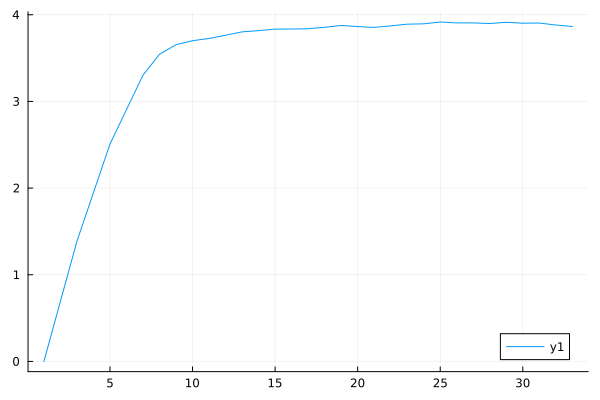

In [ ]:
using Plots
plot(S_E)

## (b) Wannier orbitals
- $\ket{\Psi}=P_G\prod_{r=1}^N\zeta_r^\dagger\ket{0}$
- Build maximally localized Wannier orbitals
    - $X=\sum_{j=1}^N\sum_{\alpha=\uparrow,\downarrow}jc_{j\alpha}^\dagger c_{j\alpha}$
    - $\tilde{X}_{mn}=\braket{0|d_mXd_n^\dagger|0}$
    - Diagonalize $\tilde{X}=B\Lambda B^\dagger$
    - The orbital: $\zeta_r^\dagger=\sum_{m=1}^NB_{mr}d_m^\dagger=\sum_{l=1}^{2N}(B^TA)_{rl}c_l^\dagger$
- Represent as MPO: $X=\begin{pmatrix}0&1\end{pmatrix}\prod_j\begin{pmatrix}1&0\\ X_j&1\end{pmatrix}\begin{pmatrix}1\\0\end{pmatrix}$ where $X_j=j(n_\uparrow+n_\downarrow)$
- Unfolding to 2N sites: $X_i=\lceil\frac{i}{2}\rceil n_i$
- J-W trafo: $X_i=\frac{1}{2}\lceil\frac{i}{2}\rceil (1-\sigma^z_i)$

In [27]:
function mpo_to_mps(mps::Vector{Array{ComplexF64, 3}}, mpo::Vector{Array{ComplexF64, 4}})
    result = Vector{Array{ComplexF64, 3}}(undef, length(mps))
    for i in 1:length(mps)
        mps_new = contract(mps[i], [2], mpo[i], [4])
        # combine legs (1, 3) and (2, 5)
        id14 = tn_identity(mps_new, 1, mps_new, 3)
        id23 = tn_identity(mps_new, 2, mps_new, 5)
        mps_new = contract(mps_new, [1, 3], id14, [1, 2])
        mps_new = contract(mps_new, [1, 3], id23, [1, 2])
        result[i] = permutedims(mps_new, (2, 1, 3))
    end
    return result
end

function expectation(mps1::Vector{Array{ComplexF64, 3}}, mps2::Vector{Array{ComplexF64, 3}}, mpo::Vector{Array{ComplexF64, 4}})
    result = reshape([1], (1,1,1))
    for i in 1:length(mps1)
        result = updateLeft(result, mps2[i], mpo[i], mps1[i])
    end
    return result[1, 1, 1]
end

function index_transform(n::Int)
    return k_vec[ceil(Int, n/2)], 1 - mod(n, 2)    
end

index_transform (generic function with 1 method)

- $k_n=k(\lceil n/2\rceil)$
- $\alpha_n=1-\mathrm{mod}_2 n$

In [28]:
X = Vector{Array{ComplexF64, 4}}(undef, 2N)
for i in 1:2N
    X[i] = zeros(ComplexF64, 2, 2, 2, 2)  # MPO for X operator
    X[i][1, :, 1, :] = id # identity operator
    X[i][2, :, 2, :] = id # identity operator
    X[i][2, :, 1, :] = ceil(i/2) / 2 .* (id-sz)
end
X[1] = contract([0 1], [2], X[1], [1])
X[2N] = permutedims(contract(X[2N], [3], [1 0], [2]), (1,2,4,3))

X_mat = Matrix{ComplexF64}(undef, N, N)
for (m, n) in Iterators.product(1:N, 1:N)
    kn, alphan = index_transform(n)
    km, alpham = index_transform(m)
    dn = mpo_to_mps(mps_jw, mpo_dkalpha(kn, alphan, 2N))
    dm = mpo_to_mps(mps_jw, mpo_dkalpha(km, alpham, 2N))
    X_mat[m, n] = expectation(dn, dm, X)
end

In [ ]:
eig = eigen(X_mat)
B = eig.vectors

function wannier(r::Int)
    # r is the index of the Wannier-orbital
    # B is the matrix of eigenvectors from the previous step
    # The Wannier function is given by the r-th column of B
    W_r = Vector{Array{<:ComplexF64,4}}(undef, 2N)
    W_r[1] = zeros(ComplexF64, 1,2,2,2)
    for i in 2:2N-1
        W_r[i] = zeros(ComplexF64, 2,2,2,2)
    end
    W_r[2N] = zeros(ComplexF64, 2,2,1,2)
    for m in 1:N
        km, alpham = index_transform(m)
        W_r = W_r + B[m, r] .* mpo_dkalpha(km, alpham, 2N)
    end
    return W_r
end

function MPO_wannier(r::Int)
    W_r = Vector{Array{ComplexF64, 4}}(undef, 2N)
    for l in 1:2N
        W_r[l] = zeros(ComplexF64, 2, 2, 2, 2)  # MPO for Wannier function
        W_r[l][1, :, 1, :] = id # identity operator
        W_r[l][2, :, 2, :] = sz # sigma_z
        W_r[l][2, :, 1, :] = B[l, r] .* sp # sigma^+
    end
end

wannier (generic function with 1 method)

In [30]:
MPS_wannier = Vector{Vector{Array{ComplexF64, 3}}}(undef, N)
mps = mps_jw  # start with the Jordan-Wigner MPS
for r in 1:N
    MPS_wannier[r] = Vector{Array{ComplexF64, 3}}(undef, 2N)
    W_r = wannier(r)
    mps = applyMPO(mps, W_r, Dmax)
    MPS_wannier[r] = mps
end

In [31]:
S_W = Vector{Float64}(undef, length(MPS_wannier)+1)
S_W[1] = entanglement_entropy(mps_jw, N)
for i in 1:length(MPS_wannier)
    S_W[i+1] = entanglement_entropy(MPS_wannier[i], N)
    println("Entanglement entropy: $(S_W[i+1])")
end

Entanglement entropy: 0.29990048490440907
Entanglement entropy: 0.5998009698088875
Entanglement entropy: 0.7787679232695708
Entanglement entropy: 0.9577348767302573
Entanglement entropy: 1.091729674923499
Entanglement entropy: 1.225724473116757
Entanglement entropy: 1.3439207354502256
Entanglement entropy: 1.4602942178441787
Entanglement entropy: 1.5708668284772114
Entanglement entropy: 1.6761996061684703
Entanglement entropy: 1.7901460538705163
Entanglement entropy: 1.8995713300203585
Entanglement entropy: 2.0429526406385623
Entanglement entropy: 2.174637365650126
Entanglement entropy: 2.4244887822531878
Entanglement entropy: 2.6635210614870215
Entanglement entropy: 3.164090142761266
Entanglement entropy: 3.5856720899294756
Entanglement entropy: 3.6741100119139265
Entanglement entropy: 3.729347304164777
Entanglement entropy: 3.7623933186904486
Entanglement entropy: 3.7935321467112115
Entanglement entropy: 3.8187983472664806
Entanglement entropy: 3.834881569724789
Entanglement entropy:

In [32]:
writedlm(path * "S_E_for_W_dmax$Dmax.txt", S_W)

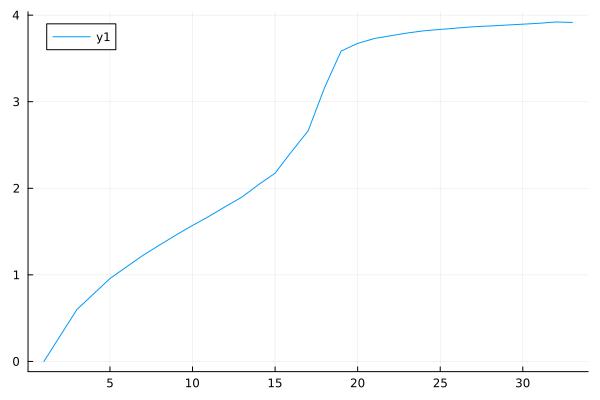

In [65]:
using Plots
plot(S_W)

### (c) Left-meets-right strategy
- Apply Wannier orbitals using the _snake geometry_ (or left-meets-right, whichever may please)
- We have: $r=\{1,2,...,N\}$
- Now $r'=\mathrm{snake}(r)=\{1,N,2,N-1,...\}$
- Implement this by concatenating $\{i, (N-i+1)\}_{i\in{1,...,\frac{N}{2}}}$

In [33]:
r_snake = collect(Iterators.flatten(((i, N - i + 1) for i in 1:div(N,2))))
MPS_snake = Vector{Vector{Array{ComplexF64, 3}}}(undef, N)
mps = mps_jw  # start with the Jordan-Wigner MPS
for (i,r) in enumerate(r_snake)
    MPS_snake[i] = Vector{Array{ComplexF64, 3}}(undef, 2N)
    W_r = wannier(r)
    mps = applyMPO(mps, W_r, Dmax)
    MPS_snake[i] = mps
end

In [40]:
check_occupation(MPS_wannier[8])

2.1396666298543036e180 - 2.7285912163904486e164im

In [34]:
S_snake = Vector{Float64}(undef, length(MPS_snake)+1)
S_snake[1] = entanglement_entropy(mps_jw, N)
for i in 1:length(MPS_snake)
    S_snake[i+1] = entanglement_entropy(MPS_snake[i], N)
    println("Entanglement entropy: $(S_snake[i+1])")
end

Entanglement entropy: 0.29990048490440907
Entanglement entropy: 0.5998009698088368
Entanglement entropy: 0.8997014547133206
Entanglement entropy: 1.1996019396177673
Entanglement entropy: 1.37856648510003
Entanglement entropy: 1.5575310008303291
Entanglement entropy: 1.736181663391763
Entanglement entropy: 1.9077860248879475
Entanglement entropy: 2.0261263543134693
Entanglement entropy: 2.1402595406756357
Entanglement entropy: 2.23717615376179
Entanglement entropy: 2.327481696360806
Entanglement entropy: 2.4178563313401686
Entanglement entropy: 2.497758525016647
Entanglement entropy: 2.5670509283825105
Entanglement entropy: 2.629604441638321
Entanglement entropy: 2.7134708357102864
Entanglement entropy: 2.7751620049873558
Entanglement entropy: 2.8375668935144716
Entanglement entropy: 2.887728226582717
Entanglement entropy: 2.9622130713082
Entanglement entropy: 3.015915713646229
Entanglement entropy: 3.0858506772392458
Entanglement entropy: 3.1243666268542185
Entanglement entropy: 3.2211

In [35]:
writedlm(path * "S_E_for_Wsnake_dmax$Dmax.txt", S_snake)

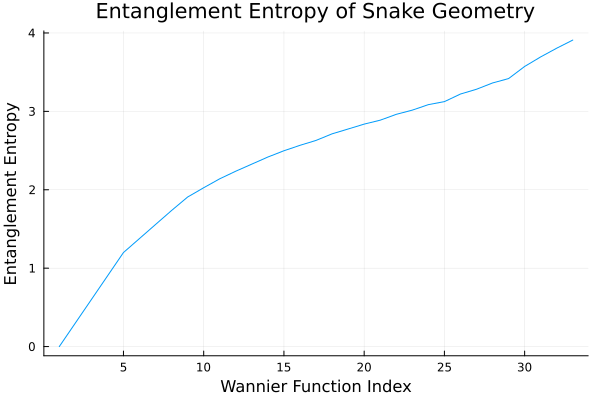

In [ ]:
plot(S_snake, title="Entanglement Entropy of Snake Geometry", xlabel="Wannier Function Index", ylabel="Entanglement Entropy", legend=false)

### (d) Constructing the Hamiltonian
- $H_\mathrm{HS}=\sum_{p<q}\frac{\pi^2\vec{S}_p\cdot\vec{S}_q}{N^2\sin^2{\frac{\pi}{N}(p-q)}}$
- We express spin operators as: $S_j^a=\frac{1}{2}\sum_{\alpha\beta}c_{j\alpha}^\dagger\tau_{\alpha\beta}^ac_{j\beta}$
- $\vec{S}_p\cdot\vec{S}_q=\frac{1}{4}\sum_{a,\alpha,\beta,\gamma,\delta}c_{p\alpha}^\dagger\tau_{\alpha\beta}^ac_{p\beta}\cdot c_{q\gamma}^\dagger\tau_{\gamma\delta}^ac_{q\delta}$
- Using the identity: $\sum_a\sigma_{\alpha\beta}^a\sigma_{\gamma\delta}^a=2\delta_{\alpha\delta}\delta_{\beta\gamma}-\delta_{\alpha\beta}\delta_{\gamma\delta}$
- We get: $\vec{S}_p\cdot\vec{S}_q=\sum_{\alpha\beta}\left(\frac{1}{2}c_{p\alpha}^\dagger c_{q\beta}^\dagger c_{q\alpha}c_{p\beta}-\frac{1}{4}n_pn_q\right)$
- So the HS fermionic Hamiltonian is: $H_{HS}=\sum_{p<q}J_{pq}\sum_{\alpha\beta}\left(\frac{1}{2}c_{p\alpha}^\dagger c_{q\beta}^\dagger c_{q\alpha}c_{p\beta}-\frac{1}{4}n_pn_q\right)$ where we denote $J_{pq}=\frac{\pi^2}{N^2\sin^2{(\frac{\pi}{N}(p-q))}}$
- After J_W: $c_{p\alpha}^\dagger c_{q\beta}^\dagger c_{q\alpha}c_{p\beta}\to\sigma_{p\alpha}^+Z_{p\alpha+1:q\beta-1}\sigma_{q\alpha}^-\sigma_{q\beta}^+Z_{q\beta+1:p\beta-1}\sigma_{p\beta}^-$
- Here $p_\alpha=2p-1+\delta_{\alpha,\downarrow}$
- Represent with finite-state-machine

In [ ]:
function Jpq(p::Int, q::Int, N::Int=N)
    # J_{pq} = π^2 / (N^2 sin^2(π/N (p-q)))
    return (pi^2 / (N^2 * sin(pi/N * (p - q))^2))
end

function H_pqab(p::Int, q::Int, a::Int, b::Int)
    D = 6  # MPO bond dimension
    d = 2  # local physical dimension
    # Compute unrolled site indices
    site_pa = 2p - 1 + a
    site_qb = 2q - 1 + b
    site_qa = 2q - 1 + a
    site_pb = 2p - 1 + b
    # Ensure sites are ordered as needed
    site_indices = [site_pa, site_qb, site_qa, site_pb]
    sorted_sites = sort(site_indices)
    min_site = minimum(site_indices)
    max_site = maximum(site_indices)
    # Initialize MPO as list of tensors
    mpo = Vector{Array{ComplexF64, 4}}(undef, 2N)
    for l in 1:2N
        W = Array{ComplexF64, 4}(undef, D, d, D, d)
        fill!(W, 0.0 + 0.0im)
        # Default: propagate identity
        for b in 1:D
            W[b, :, b, :] = id
        end
        # Determine operator placements
        if l == site_pa
            W[1, 2, :, :] = Jpq(p,q) * sp
        elseif l == site_qb
            W[2, 3, :, :] = sp
        elseif l == site_qa
            W[3, 4, :, :] = sm
        elseif l == site_pb
            W[4, 5, :, :] = sm
        elseif l > minimum(site_indices) && l < maximum(site_indices)
            # Determine where Z-strings propagate
            if (l > site_pa && l < site_qb)
                W[2,2,:,:] = sz
            end
            if (l > site_qb && l < site_qa)
                W[3,3,:,:] = sz
            end
            if (l > site_qa && l < site_pb)
                W[4,4,:,:] = sz
            end
        end

        mpo[l] = W
    end
    mpo[1] = contract([1 0 0 0 0 0], [2], mpo[1], [1])
    mpo[2N] = permutedims(contract(mpo[2N], [3], [0 0 0 0 1 0], [2]), (1,2,4,3))
    return mpo
end